In [1]:
library(igraph)
library(ggplot2)

Warning message:
"package 'igraph' was built under R version 3.6.3"
Attaching package: 'igraph'

The following objects are masked from 'package:stats':

    decompose, spectrum

The following object is masked from 'package:base':

    union

Warning message:
"package 'ggplot2' was built under R version 3.6.2"

# Stock Market

In [2]:
stock_path <- "finance_data\\data"
sector_path <- "finance_data"

In [3]:
stock_names <- unlist(sapply(list.files(path = stock_path),function (x) {strsplit(x,".csv")}))
names(stock_names) <- NULL

In [4]:
stocks_dfs <- lapply(list.files(path = stock_path),
       function (x) {read.csv(file.path(stock_path, x),stringsAsFactors=FALSE)})

In [5]:
names(stocks_dfs) <-stock_names

In [6]:
sector_df <- read.csv(file.path(sector_path,"Name_sector.csv"),stringsAsFactors=FALSE)

## Question 1

In [7]:
stock_return = function (p){
    q <- diff(p)/p[1:(length(p)-1)]
    return(q)
}

In [8]:
log_norm_stock_return = function(q){
    return(log(1+q))
}

In [9]:
create_stock_correlation_adj = function(stocks_dfs,sector_df){
    N_stocks <- nrow(sector_df)
    stock_correlation_matrix <- matrix(nrow=N_stocks,
           ncol=N_stocks,
           dimnames=list(stock_names,stock_names))
    stock_correlation_matrix[is.na(stock_correlation_matrix)] <- 0

    for (i in 1:(nrow(sector_df)-1)){
        for (j in (i+1):nrow(sector_df)){
            stocki <- stocks_dfs[[i]]
            stockj <- stocks_dfs[[j]]

            stocki_date <- stocki$Date
            stockj_date <- stockj$Date

            idxi <- (stocki_date %in% stockj_date)
            idxj <- (stockj_date %in% stocki_date)

            if (!sum(idxi) | !sum(idxj)){
                #print(sprintf("Stocks %s and %s have no correlation",stock_names[i],stock_names[j]))
                stock_correlation_matrix[i,j] <- 0
                next
            }

            p1 <- stocki$Close[idxi]
            p2 <- stockj$Close[idxj]

            q1 <- stock_return(p1)
            q2 <- stock_return(p2)

            r1 <- log_norm_stock_return(q1)
            r2 <- log_norm_stock_return(q2)

            correlation_ij <- cor(r1,r2)#(mean(r1*r2) - mean(r1)*mean(r2)) / sqrt((mean(r1^2) - mean(r1)^2) * (mean(r2^2)*mean(r2)^2))
            stock_correlation_matrix[i,j] <- correlation_ij
        }   
    }

    stock_correlation_matrix[is.na(stock_correlation_matrix)] <- 0
    stock_correlation_matrix <- t(stock_correlation_matrix) + stock_correlation_matrix
    diag(stock_correlation_matrix) <- 1
    return(stock_correlation_matrix)
}

In [10]:
stock_correlation_matrix <- create_stock_correlation_adj(stocks_dfs,sector_df)

In [11]:
#heatmap(stock_correlation_matrix,Colv = NA, Rowv = NA)

In [12]:
print_str <- sprintf("The Min-Max numerical bounds we found are (%.4f,%.4f)",min(stock_correlation_matrix),max(stock_correlation_matrix))
print(print_str)

[1] "The Min-Max numerical bounds we found are (-0.1986,1.0000)"


## Question 2

In [13]:
create_stock_correlation_graph = function(stock_correlation_matrix,sector_df){
    correlation_adj <- sqrt(2*(1-stock_correlation_matrix)) #+ 1^-16))
    correlation_graph <- graph_from_adjacency_matrix(correlation_adj,mode='undirected',weighted=TRUE)
    V(correlation_graph)$sector <- sector_df$Sector
    return(correlation_graph)
}

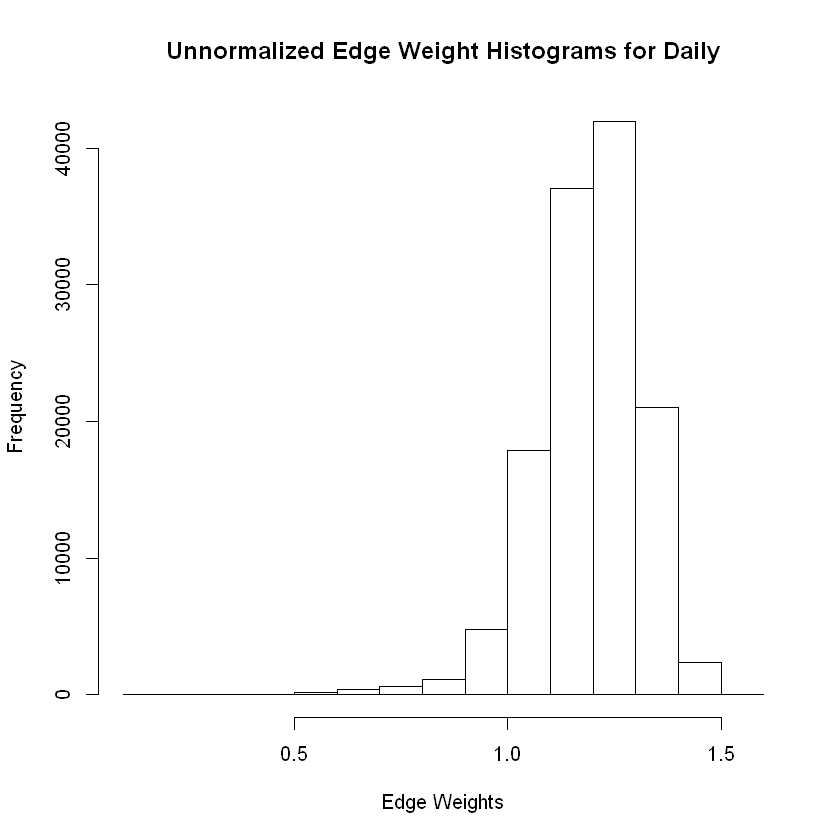

In [14]:
correlation_graph <- create_stock_correlation_graph(stock_correlation_matrix,sector_df)
hist(E(correlation_graph)$weight,xlab = "Edge Weights",main="Unnormalized Edge Weight Histograms for Daily")

## Question 3

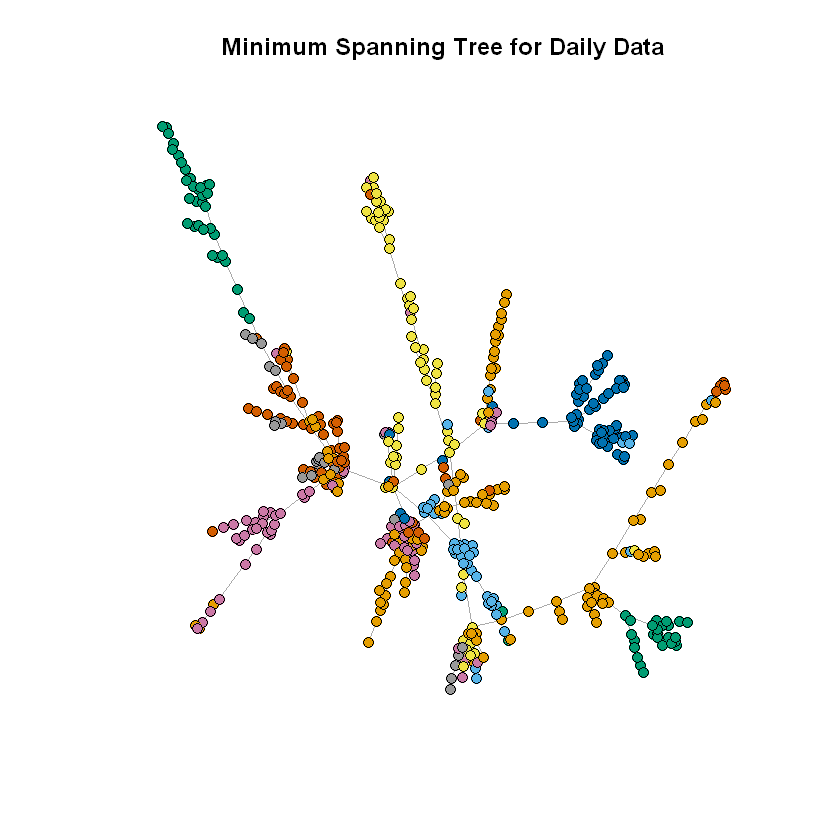

In [15]:
mst_correlation_graph <- mst(correlation_graph)
plot(mst_correlation_graph,
     vertex.size=4,
     edge.width=0.1,
     vertex.label=NA,
     edge.arrow.size=0.2,
    vertex.color=factor(sector_df$Sector),
    main="Minimum Spanning Tree for Daily Data")

## Sector Clustering in MST's

In [16]:
sector_clustering <- cluster_fast_greedy(mst_correlation_graph)

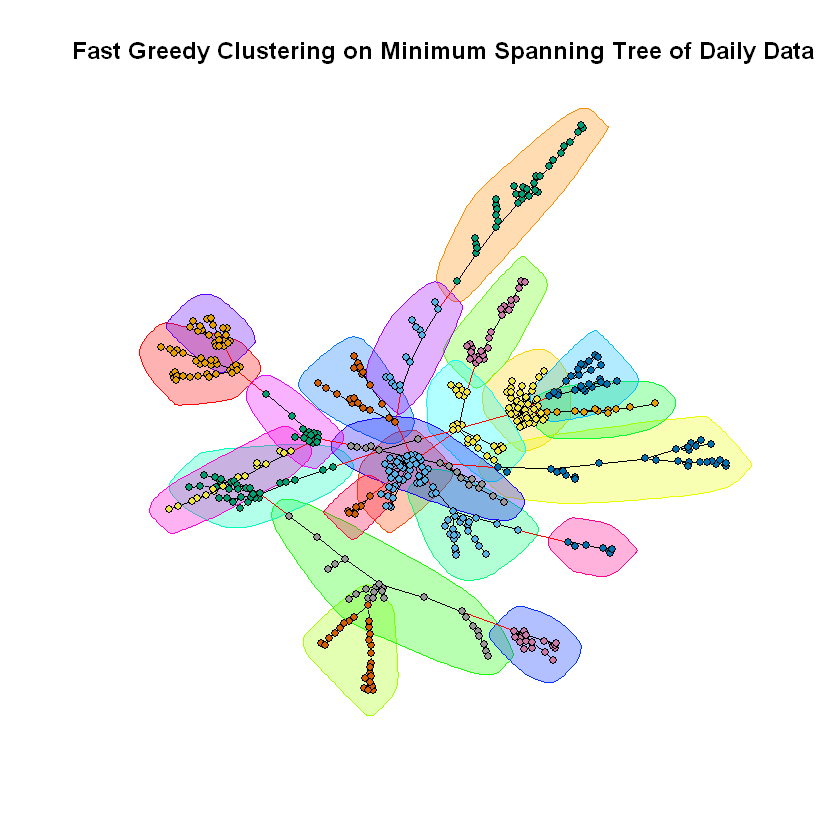

In [17]:
plot(sector_clustering,
     mst_correlation_graph,
             vertex.label=NA,
             vertex.size=3,
             edge.width = 0.2,
             margin=c(0,0,0,0),
    main="Fast Greedy Clustering on Minimum Spanning Tree of Daily Data")

In [18]:
alpha_q <- 0
alpha_s <- 0
for (nodei in V(mst_correlation_graph)$name){
    nodei_sector <- get.vertex.attribute(mst_correlation_graph,'sector',index=nodei)
    nodei_neighbor_sectors <- neighbors(mst_correlation_graph,nodei)$sector
    qi <- sum(nodei_sector == nodei_neighbor_sectors)
    si <- sum(nodei_sector == V(mst_correlation_graph)$sector)
    alpha_q <- alpha_q + qi / length(nodei_neighbor_sectors)
    alpha_s <- alpha_s + si / vcount(mst_correlation_graph)
}
alpha_q <- alpha_q / vcount(mst_correlation_graph)
alpha_s <- alpha_s / vcount(mst_correlation_graph)

In [19]:
sprintf("Alpha q: %.4f , Alpha s: %.4f",alpha_q,alpha_s)

[1] "Alpha q: 0.8193 , Alpha s: 0.1146"

## Question 5

In [20]:
stocks_dfs_mondays <- lapply(stocks_dfs,function (x) {x[weekdays(as.Date(x$Date))=="Monday",]})

In [21]:
stock_correlation_matrix_mondays <- create_stock_correlation_adj(stocks_dfs_mondays,sector_df)

In [22]:
print_str <- sprintf("The Min-Max numerical bounds we found are (%.4f,%.4f)",min(stock_correlation_matrix_mondays),max(stock_correlation_matrix_mondays))
print(print_str)

[1] "The Min-Max numerical bounds we found are (-0.4412,1.0000)"


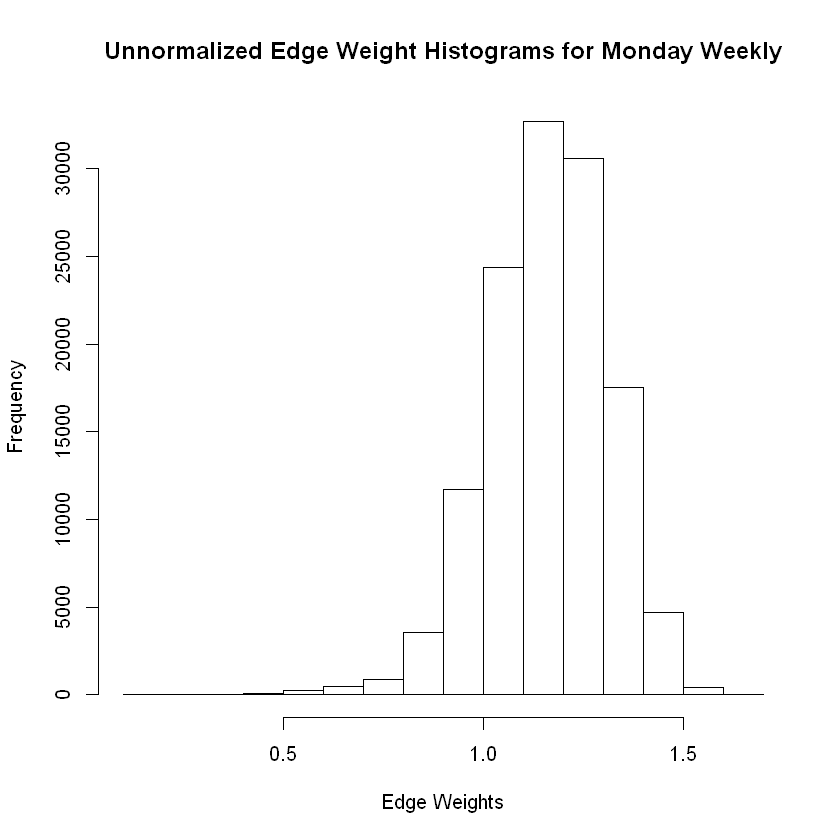

In [23]:
correlation_graph_mondays <- create_stock_correlation_graph(stock_correlation_matrix_mondays,sector_df)
hist(E(correlation_graph_mondays)$weight,xlab = "Edge Weights",main="Unnormalized Edge Weight Histograms for Monday Weekly")

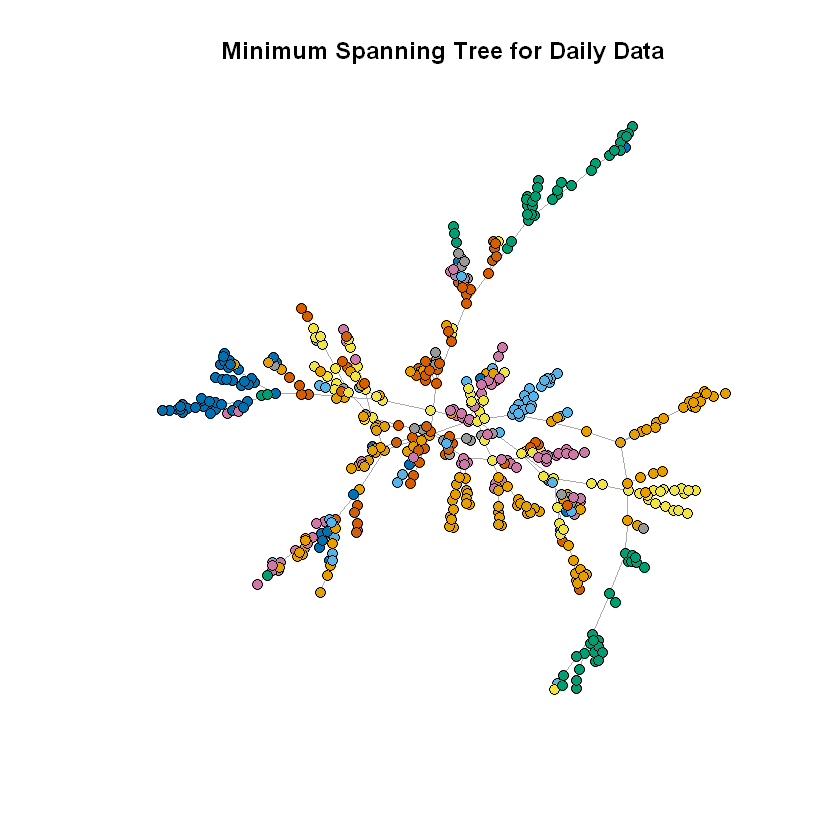

In [24]:
mst_correlation_graph_mondays <- mst(correlation_graph_mondays)
plot(mst_correlation_graph_mondays,
     vertex.size=4,
     edge.width=0.1,
     vertex.label=NA,
     edge.arrow.size=0.2,
    vertex.color=factor(sector_df$Sector),
    main="Minimum Spanning Tree for Daily Data")

In [25]:
alpha_q_mondays <- 0
alpha_s_mondays <- 0
for (nodei in V(mst_correlation_graph_mondays)$name){
    nodei_sector <- get.vertex.attribute(mst_correlation_graph_mondays,'sector',index=nodei)
    nodei_neighbor_sectors <- neighbors(mst_correlation_graph_mondays,nodei)$sector
    qi <- sum(nodei_sector == nodei_neighbor_sectors)
    si <- sum(nodei_sector == V(mst_correlation_graph_mondays)$sector)
    alpha_q_mondays <- alpha_q_mondays + qi / length(nodei_neighbor_sectors)
    alpha_s_mondays <- alpha_s_mondays + si / vcount(mst_correlation_graph_mondays)
}
alpha_q_mondays <- alpha_q_mondays / vcount(mst_correlation_graph_mondays)
alpha_s_mondays <- alpha_s_mondays / vcount(mst_correlation_graph_mondays)

In [26]:
sprintf("Alpha q: %.4f , Alpha s: %.4f",alpha_q_mondays,alpha_s_mondays)

[1] "Alpha q: 0.7367 , Alpha s: 0.1146"